### Let's explore ocean surface circulation patterns

In [1]:
import numpy as np
import pandas as pd
#import xarray as xr
import os
import netCDF4 as nc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import scipy.stats as sci_stats

In [2]:
os.chdir('/home/openonic/global-drifter-program/')
circ = nc.Dataset('data/circulation.nc')

In [3]:
circ

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.11
    title: Mean Dynamic Topography
    institution: CLS, CNES, CMEMS
    source: Altimetry measurements, gravimetry (icluding GOCE and GRACE) and in-situ data.
    history: 2020-07-29T10:52:01Z : Creation 
    contact: servicedesk.cmems@mercator-ocean.eu, smulet@groupcls.com, sjousset@groupcls.com
    references: Mulet et al, 2021; Jousset et al, 2022
    subset:source: ARCO data downloaded from the Marine Data Store using the MyOcean Data Portal
    subset:productId: SEALEVEL_GLO_PHY_MDT_008_063
    subset:datasetId: cnes_obs-sl_glo_phy-mdt_my_0.125deg_P20Y_202012--ext--mdt
    subset:date: 2024-07-23T00:22:01.830Z
    dimensions(sizes): latitude(1440), longitude(2880), time(1)
    variables(dimensions): float32 latitude(latitude), float32 longitude(longitude), float64 time(time), float32 u(time,latitude,longitude), float32 v(time,latitude,longitude)
    groups: 

In [4]:
circ.variables.keys()

dict_keys(['latitude', 'longitude', 'time', 'u', 'v'])

In [5]:
u = np.array(circ.variables['u'])[0]
v = np.array(circ.variables['v'])[0]
lats = np.array(circ.variables['latitude'])
lons = np.array(circ.variables['longitude'])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_la

In [65]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

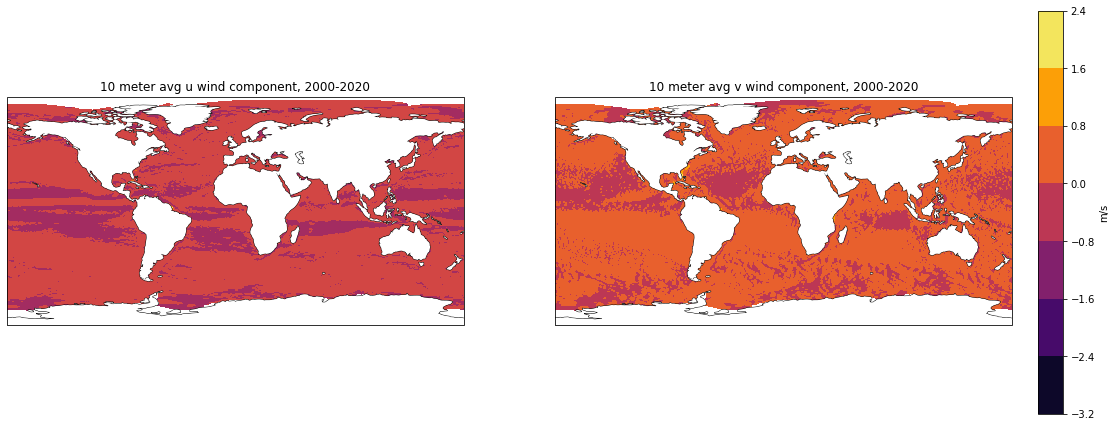

In [6]:
# Create the figure and the axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, u, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons, lats, v, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('10 meter avg v wind component, 2000-2020')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

In [21]:
from scipy.ndimage import generic_filter

def average_surrounding_cells(df, layers=20, strength=1.5):
    # Define the footprint for the filter
    size = 2 * layers + 1
    
    # Custom function to apply within the filter
    def mean_filter(values):
        valid_values = values[~np.isnan(values)]
        if valid_values.size == 0:
            return np.nan
        return np.mean(valid_values) * strength + values[size**2 // 2] * (1 - strength)
    
    # Apply the generic filter
    averaged_data = generic_filter(df.to_numpy(), mean_filter, size=size, mode='constant', cval=np.nan)
    
    return pd.DataFrame(averaged_data, index=df.index, columns=df.columns)

In [22]:
smoothed_u = average_surrounding_cells(pd.DataFrame(u))
smoothed_v = average_surrounding_cells(pd.DataFrame(v))

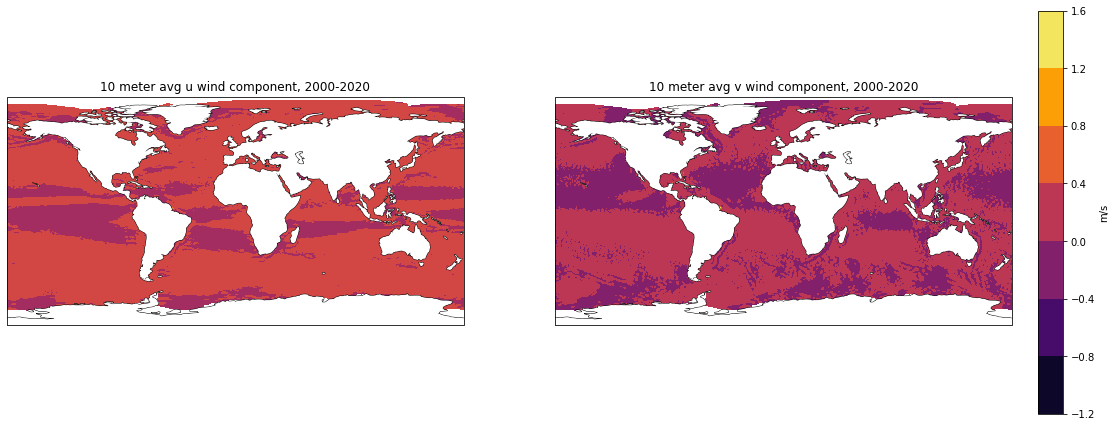

In [23]:
# Create the figure and the axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, smoothed_u.values, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons, lats, smoothed_v.values, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('10 meter avg v wind component, 2000-2020')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

In [10]:
# load probability of beaching data
os.chdir('/dat1/openonic/Drifters') # directory
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

In [11]:
# we follow the steps in the probability of beaching notebook:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

In [12]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [13]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe
beach_prob = pd.DataFrame(probability_undrogued)
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [14]:
desired_rows = 360
desired_cols = 180
lats_2 = np.linspace(-90,90,desired_cols)
lons_2 = np.linspace(-180, 180, desired_rows)

In [15]:
np.shape(beach_prob_vals)

(180, 360)

In [30]:
os.chdir('/home/openonic/global-drifter-program/')

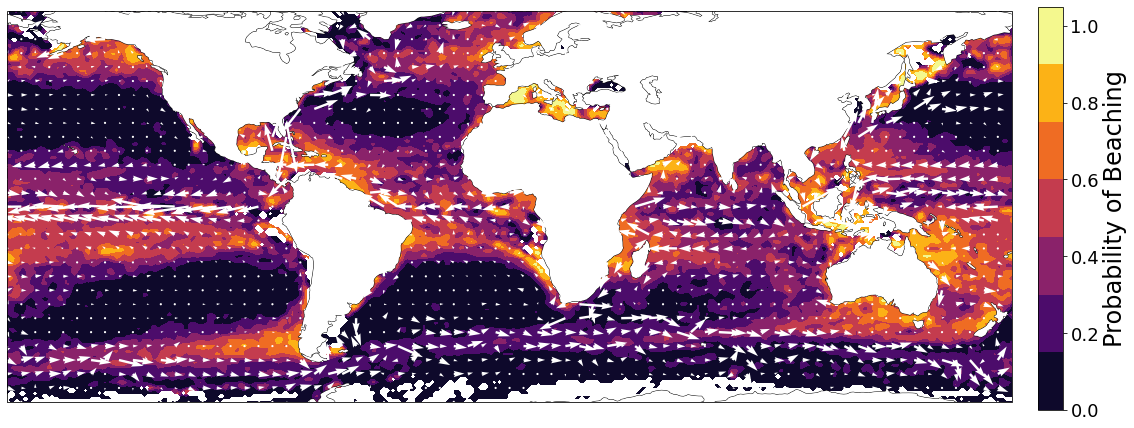

In [66]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons_2, lats_2, beach_prob_vals_filtered, cmap='inferno', transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, levels = 6)
#ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color='black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Probability of Beaching')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
im1.set_clim(0, 1.0)  # This sets the color limits for the ScalarMappable


# Plot wind vectors
nth = 40
wind_q_global = ax1.quiver(lons[::nth], lats[::nth], smoothed_u.values[::nth, ::nth], smoothed_v.values[::nth, ::nth], color='white', scale=8)

# Save the figure in high resolution
plt.savefig('prob_beach_circulation.png', dpi=300)

# Show the plot
plt.show()

In [55]:
np.shape(beach_prob_vals)

(180, 360)

In [68]:
def nan_gaussian_filter(values, sigma=0.45):
    mask = np.isnan(values)
    values_filled = np.where(mask, np.nanmean(values), values)  # Replace NaNs with the mean of non-NaNs
    filtered = gaussian_filter(values_filled, sigma=sigma)
    filtered[mask] = np.nan  # Restore NaNs
    return filtered

# Apply the custom Gaussian filter
beach_prob_vals_filtered = nan_gaussian_filter(beach_prob_vals, sigma=0.7)

beach_prob_vals_filtered2 = nan_gaussian_filter(beach_prob_vals, sigma=0.1)

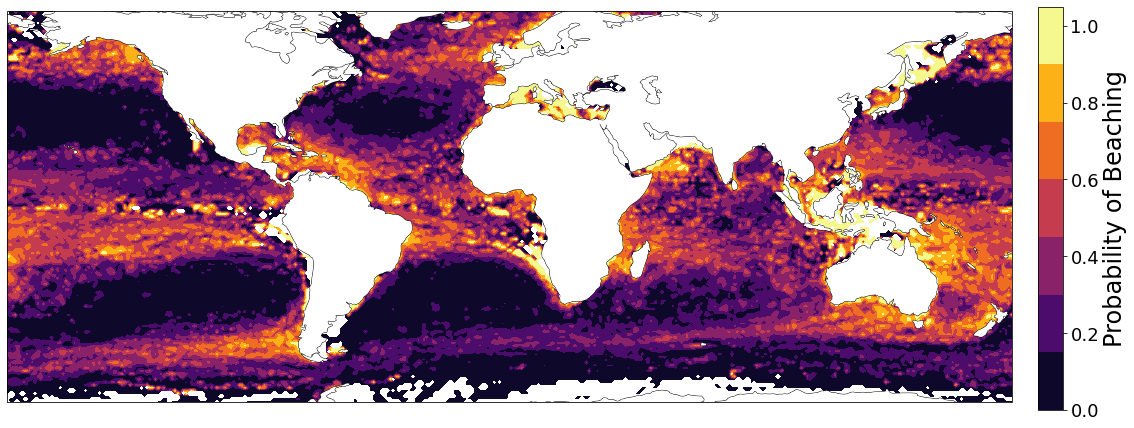

In [69]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons_2, lats_2, beach_prob_vals_filtered2, cmap='inferno', transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, levels = 6)
#ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color='black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Probability of Beaching')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
im1.set_clim(0, 1.0)  # This sets the color limits for the ScalarMappable

## Plot wind vectors
#nth = 30
#wind_q_global = ax1.quiver(lons[::nth], lats[::nth], smoothed_u.values[::nth, ::nth], smoothed_v.values[::nth, ::nth], color='white', scale=8)

# Save the figure in high resolution
plt.savefig('prob_beach.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
wind_q = ax.quiver(X[::4], Y[::4], u_winds_list[::4], v_winds_list[::4], color='blue', scale=190)

In [ ]:
10*np.nanstd(u)

0.8964724093675613

(-0.44823620468378067, 0.44823620468378067)

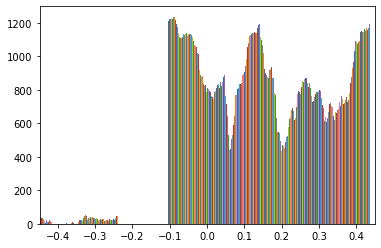

In [ ]:
plt.hist(u)
plt.xlim(-5*np.nanstd(u), 5*np.nanstd(u))

(-0.2877291105687618, 0.2877291105687618)

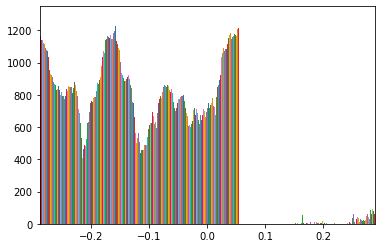

In [ ]:
plt.hist(v)
plt.xlim(-5*np.nanstd(v), 5*np.nanstd(v))